In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10955034232963466355
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 18406921539790191657
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3669128541512179202
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14648777152
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5730899627928035030
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [3]:
!pip install bert-tensorflow


In [4]:
!pip install pytorch-pretrained-bert

In [5]:
import pandas as pd
import numpy as np
import torch.nn as nn
from pytorch_pretrained_bert import BertTokenizer, BertModel
import torch
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split



Using TensorFlow backend.


In [0]:
real = pd.read_csv('/content/gdrive/My Drive/twitter misinfo/2020_04_10000_real_tweets.csv', header = None)
fake = pd.read_csv('/content/gdrive/My Drive/twitter misinfo/2020_04_10000_fake_tweets_unconditional.csv', header = None)

In [0]:
real.columns = ['tweet']
real['index'] = real.index
fake.columns = ['tweet']
fake['index'] = fake.index
cols = real.columns.tolist()
cols = cols[-1:] + cols[:-1]
real = real[cols]
cols = fake.columns.tolist()
cols = cols[-1:] + cols[:-1]
fake = fake[cols]

In [8]:
real['is_fake'] = False
fake['is_fake'] = True
real.head()

,index,tweet,is_fake
0,0,#Taiwan isn't a member of the #WHO. Taiwan tr...,False
1,1,From the DJs to the CJs.. Look whose in the PJ...,False
2,2,The @ClinicalBioinfo led by @xdopazo releases ...,False
3,3,IMF expects #Greece to be the worst hit econom...,False
4,4,More on #COVID19 - China witnessed a slight in...,False


In [9]:
fake.head()

,index,tweet,is_fake
0,0,@chrislhayes I think it's important to note th...,True
1,1,"The problem is, it's the Chinese that are bein...",True
2,2,Do you know of any people who are looking for ...,True
3,3,Just as the COVID-19 pandemic has shown that t...,True
4,4,Covid-19's impact on the economy: The RBC Stat...,True


In [10]:
num_tweets = min(len(real), len(fake))
real = real[:num_tweets]
fake = fake[:num_tweets]

print(len(real))
print(len(fake))

9997
9997


In [11]:
# combined = pd.concat([fake, real])
# features = combined['tweet']
# labels = combined['label']
# combined = combined.sample(frac = 1).reset_index(drop = True)
# combined['index'] = combined.index
# combined.tail()

from sklearn.utils import shuffle

combined = pd.concat([real, fake])
combined = shuffle(combined, random_state = 42).reset_index(drop=True)
combined.head()

,index,tweet,is_fake
0,8885,Australia has a lot to worry about from the CO...,True
1,2140,Spain to implement universal basic income to h...,False
2,6110,"Cuomo on the pandemic: ""I want it to be over t...",False
3,4528,I can’t believe it's been only 2 months since ...,True
4,868,Reminder: Not all cases of #COVID19 are connec...,True


In [12]:
train_data, validate_data, test_data = np.split(combined.sample(frac=1), [int(.6*len(combined)), int(.8*len(combined))])

train_data = train_data.reset_index(drop = True)
validate_data = validate_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

del real
del fake

print("Size of training set: {}".format(len(train_data)))
print("Size of validation set: {}".format(len(validate_data)))
print("Size of testing set: {}".format(len(test_data)))

Size of training set: 11996
Size of validation set: 3999
Size of testing set: 3999


In [13]:
!pip install torch torchvision
!pip install transformers

In [0]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased")
model.config.num_labels = 1

In [0]:
# Freeze the pre trained parameters
for param in model.parameters():
    param.requires_grad = False

# Add three new layers at the end of the network
model.classifier = nn.Sequential(
    nn.Linear(768, 256),
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Linear(64, 2),
    nn.Softmax(dim=1)
)

model = model.to(device)

In [0]:
criterion = nn.MSELoss().to(device)
optimizer = optim.SGD(model.classifier.parameters(), lr=0.01)

In [0]:
def preprocess_text(text):
    parts = []

    text_len = len(text.split(' '))
    delta = 300
    max_parts = 5
    nb_cuts = int(text_len / delta)
    nb_cuts = min(nb_cuts, max_parts)
    
    
    for i in range(nb_cuts + 1):
        text_part = ' '.join(text.split(' ')[i * delta: (i + 1) * delta])
        parts.append(tokenizer.encode(text_part, return_tensors="pt", max_length=500).to(device))

    return parts

In [18]:
print_every = 300

total_loss = 0
all_losses = []

CUDA_LAUNCH_BLOCKING=1

model.train()

for idx, row in train_data.iterrows():
    text_parts = preprocess_text(str(row['tweet']))
    label = torch.tensor([row['is_fake']]).long().to(device)

    optimizer.zero_grad()

    overall_output = torch.zeros((1, 2)).float().to(device)
    for part in text_parts:
        if len(part) > 0:
            try:
                input = part.reshape(-1)[:512].reshape(1, -1)
                # print(input.shape)
                overall_output += model(input, labels=label)[1].float().to(device)
            except Exception as e:
                print(str(e))

#     overall_output /= len(text_parts)
    overall_output = F.softmax(overall_output[0], dim=-1)

    if label == 0:
        label = torch.tensor([1.0, 0.0]).float().to(device)
    elif label == 1:
        label = torch.tensor([0.0, 1.0]).float().to(device)

    # print(overall_output, label)

    loss = criterion(overall_output, label)
    total_loss += loss.item()
    
    loss.backward()
    optimizer.step()

    if idx % print_every == 0 and idx > 0:
        average_loss = total_loss / print_every
        print("{}/{}. Average loss: {}".format(idx, len(train_data), average_loss))
        all_losses.append(average_loss)
        total_loss = 0

300/11996. Average loss: 0.250870574315389
600/11996. Average loss: 0.24909981116652488
900/11996. Average loss: 0.2499700610836347
1200/11996. Average loss: 0.24677096058924994
1500/11996. Average loss: 0.25035194714864095
1800/11996. Average loss: 0.2477052635947863
2100/11996. Average loss: 0.24555524309476218
2400/11996. Average loss: 0.24869394411643347
2700/11996. Average loss: 0.24648641313115754
3000/11996. Average loss: 0.24722626189390817
3300/11996. Average loss: 0.2481484118103981
3600/11996. Average loss: 0.2471695575118065
3900/11996. Average loss: 0.24393518735965092
4200/11996. Average loss: 0.23873270332813262
4500/11996. Average loss: 0.24307275834182898
4800/11996. Average loss: 0.24171389785905678
5100/11996. Average loss: 0.23226040966808795
5400/11996. Average loss: 0.23916454032063483
5700/11996. Average loss: 0.23143731169402598
6000/11996. Average loss: 0.24016351347168285
6300/11996. Average loss: 0.23620224366585413
6600/11996. Average loss: 0.237250655889511

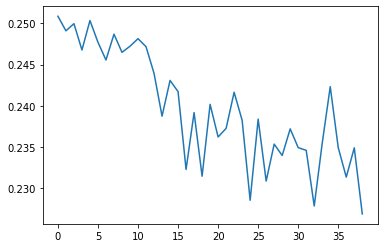

In [19]:
import matplotlib.pyplot as plt

%matplotlib inline
torch.save(model.state_dict(), "model_after_train.pt")

plt.plot(all_losses)

In [20]:
total = len(test_data)
number_right = 0
model.eval()
with torch.no_grad():
    for idx, row in test_data.iterrows():
        text_parts = preprocess_text(str(row['tweet']))
        label = torch.tensor([row['is_fake']]).float().to(device)
        
        overall_output = torch.zeros((1,2)).to(device)
        try:
            for part in text_parts:
                if len(part) > 0:
                    overall_output += model(part.reshape(1, -1))[0]
        except RuntimeError:
            print("GPU out of memory, skipping this entry.")
            continue
            
        overall_output = F.softmax(overall_output[0], dim=-1)
            
        result = overall_output.max(0)[1].float().item()
 
        if result == label.item():
            number_right += 1
            
        if idx % print_every == 0 and idx > 0:
            print("{}/{}. Current accuracy: {}".format(idx, total, number_right / idx))
            
print("Accuracy on test data: {}".format(number_right / total))

300/3999. Current accuracy: 0.7
600/3999. Current accuracy: 0.6666666666666666
900/3999. Current accuracy: 0.6611111111111111
1200/3999. Current accuracy: 0.6575
1500/3999. Current accuracy: 0.658
1800/3999. Current accuracy: 0.6583333333333333
2100/3999. Current accuracy: 0.66
2400/3999. Current accuracy: 0.6616666666666666
2700/3999. Current accuracy: 0.6588888888888889
3000/3999. Current accuracy: 0.659
3300/3999. Current accuracy: 0.6581818181818182
3600/3999. Current accuracy: 0.6580555555555555
3900/3999. Current accuracy: 0.6635897435897435
Accuracy on test data: 0.6624156039009752


In [0]:
def test(text):
    text_parts = preprocess_text(text)
    overall_output = torch.zeros((1,2)).to(device)
    try:
        for part in text_parts:
            if len(part) > 0:
                overall_output += model(part.reshape(1, -1))[0]
    except RuntimeError:
        print("GPU out of memory, skipping this entry.")

    overall_output = F.softmax(overall_output[0], dim=-1)

    value, result = overall_output.max(0)

    term = "fake"
    if result.item() == 0:
        term = "real"

    print("{} at {}%".format(term, value.item() * 100))

In [22]:
fake1 = """
Americans to fund killing babies in abortion that she has been caught trying to add taxpayer financing of abortions to the bill to combat the Coronavirus and provide economic stimulus to the nation as it deals with the COVD-19 outbreak.
Nancy Pelosi has a long history of promoting abortion and her first act after becoming Speaker in 2019 was pushing legislation to use tax money for abortions. So it’s no surprise she is trying to exploit the Coronavirus pandemic to push abortion funding again.
As The Daily Caller reports: House Speaker Nancy Pelosi sought to include a potential way to guarantee federal funding for abortion into the coronavirus economic stimulus plan, according to multiple senior White House officials.
Speaking to the Daily Caller, those officials alleged that while negotiating the stimulus with U.S. Treasury Secretary Steve Mnuchin, Pelosi tried to lobby for “several” provisions that stalled bipartisan commitment to the effort. One was a mandate for up to $1 billion to reimburse laboratory claims, which White House officials say would set a precedent of health spending without protections outlined in the Hyde Amendment.
LifeNews depends on the support of readers like you to combat the pro-abortion media. Please donate now.
“A New mandatory funding stream that does not have Hyde protections would be unprecedented,” one White House official explained. “Under the guise of protecting people, Speaker Pelosi is working to make sure taxpayer dollars are spent covering abortion—which is not only backwards, but goes against historical norms.”
A second White House official referred to the provision as a “slush fund” and yet another questioned “what the Hyde Amendment and abortion have to do with protecting Americans from coronavirus?”
Americans should insist to their members of Congress that we need a clean bill that provides aggressive action to help patients and spur the economy. Killing babies with our tax dollars is not the answer to the coronavirus and the situation should not be exploited for political gain.
"""

true1 = """
Price spikes, however, would cause demand to wither and some expensive avocados might be leftover, and stores might try to ration avocados, he added.
"Exactly what the retail strategy would be in this case, I’m not sure. But we would have vastly fewer avocados," Sumner said.
Just how fast avocados would disappear, if at all, would depend on whether the Trump administration enacts a full or partial border closure. White House economic adviser Larry Kudlow told CNBC he’s looking for ways to keep some commerce flowing.
"We are looking at different options, particularly if you can keep those freight lanes, the truck lanes, open," he said this week.  
Ben Holtz owns Rocky H Ranch, a 70-acre family-run avocado farm in northern San Diego County. He agreed avocados would run out within weeks.
"Mexico is the big player today. California is not. You shut down the border and California can’t produce to meet the demand," Holtz said. "There will be people without their guacamole."
While Mexico’s avocado harvest is year-round, California’s is limited to April through July. Growers in the state have picked only about 3 percent of what’s expected to be a much smaller crop of about 175 million pounds this year, Holtz said. A heat wave last summer reduced the crop size.
California’s avocado harvest has averaged approximately 300 million pounds in recent years, according to data from the California Avocado Commission. By contrast, the U.S. has imported more than 1.5 billion pounds of avocados from Mexico annually. Representatives from the commission did not respond to requests for this article.
Altogether, the U.S. received 43 percent of its fruit and vegetable imports from Mexico in 2016, according to the U.S. Department of Agriculture.
Also affecting this year’s avocado supply, a California avocado company in March recalled shipments to six states last month after fears the fruit might be contaminated with a bacterium that can cause health risks.
Until the early 2000s, California was the nation’s leading supplier of avocados, Holtz said. Mexico gradually overtook the state and now dominates sales in the U.S.
"It’s a very big possibility," Holtz said of avocado shortages. "Three weeks would dry up the Mexican inventory. California alone consumes more avocados than are grown in our state. Cold storage supply chain is basically three weeks or less of inventory. Most of the time it’s seven days."
A spokeswoman for the California Restaurant Association said "we haven’t heard concerns from restaurants, it doesn’t mean they aren’t worried." A national grocers association said it will "continue to closely monitor any developments" at the border, but did not have information about the potential impact on avocados.
"""

test(fake1)
test(true1)

fake at 73.37016463279724%
fake at 77.71880626678467%
